# Tutorial: Modern Pandas - Visualization & Exploratory Analysis (Part 6)
This tutorial can be accessed [here](https://github.com/TomAugspurger/effective-pandas/blob/master/modern_6_visualization.ipynb).

A few weeks ago, the R community went through some hand-wringing about plotting packages. For outsiders (like me) the details aren't that important, but some brief background might be useful so we can transfer the takeaways to Python. The competing systems are "base R", which is the plotting system built into the language, and ggplot2, Hadley Wickham's implementation of the grammar of graphics. For those interested in more details, start with

* [Why I Don't Use ggplot2](https://simplystatistics.org/2016/02/11/why-i-dont-use-ggplot2/)
* [Why I use ggplot2](http://varianceexplained.org/r/why-I-use-ggplot2/)
* [Comparing ggplot2 and base r graphics](http://flowingdata.com/2016/03/22/comparing-ggplot2-and-r-base-graphics/)

The most important takeaways are that

1. Either system is capable of producing anything the other can
2. ggplot2 is usually better for exploratory analysis

Item 2 is not universally agreed upon, and it certainly isn't true for every type of chart, but we'll take it as fact for now. I'm not foolish enough to attempt a formal analogy here, like "matplotlib is python's base R". But there's at least a rough comparison: like dplyr/tidyr and ggplot2, the combination of pandas and seaborn allows for fast iteration and exploration. When you need to, you can "drop down" into matplotlib for further refinement.

## Library

In [1]:
import os
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Configurations

In [2]:
if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

## Overview
Here's a brief sketch of the plotting landscape as of April 2016. For some reason, plotting tools feel a bit more personal than other parts of this series so far, so I feel the need to blanket this who discussion in a caveat: this is my personal take, shaped by my personal background and tastes. Also, I'm not at all an expert on visualization, just a consumer. For real advice, you should [listen](https://twitter.com/mbostock) to the [experts](https://twitter.com/oceankidbilly) in this [area](https://twitter.com/arnicas). Take this all with an extra grain or two of salt.

## [Matplotlib](http://matplotlib.org/)
Matplotlib is an amazing project, and is the foundation of pandas' built-in plotting and Seaborn. It handles everything from the integration with various drawing backends, to several APIs handling drawing charts or adding and transforming individual glyphs (artists). I've found knowing the [pyplot API](http://matplotlib.org/api/pyplot_api.html) useful. You're less likely to need things like [Transforms](http://matplotlib.org/users/transforms_tutorial.html) or [artists](http://matplotlib.org/api/artist_api.html), but when you do the documentation is there.

Matplotlib has built up something of a bad reputation for being verbose. I think that complaint is valid, but misplaced. Matplotlib lets you control essentially anything on the figure. An overly-verbose API just means there's an opportunity for a higher-level, domain specific, package to exist (like seaborn for statistical graphics).

## [Pandas' Builtin-plotting](http://pandas.pydata.org/pandas-docs/version/0.18.0/visualization.html)
`DataFrame` and `Series` have a `.plot` namespace, with various chart types available (`line`, `hist`, `scatter`, etc.). Pandas objects provide additional metadata that can be used to enhance plots (the Index for a better automatic x-axis then `range(n)` or `Index` names as axis labels for example).

And since pandas had fewer backwards-compatibility constraints, it had a bit better default aesthetics. The [matplotlib 2.0 release](http://matplotlib.org/style_changes.html) will level this, and pandas has [deprecated its custom plotting styles](https://github.com/pydata/pandas/issues/11783), in favor of matplotlib's (technically [I just broke it](https://github.com/pydata/pandas/issues/11727) when fixing matplotlib 1.5 compatibility, so we deprecated it after the fact).

At this point, I see pandas DataFrame.plot as a useful exploratory tool for quick throwaway plots.

## [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/)
[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/), created by Michael Waskom, "provides a high-level interface for drawing attractive statistical graphics." Seaborn gives a great API for quickly exploring different visual representations of your data. We'll be focusing on that today.

## [Bokeh](http://bokeh.pydata.org/en/latest/)
[Bokeh](http://bokeh.pydata.org/en/latest/) is a (still under heavy development) visualization library that targets the browser.

Like matplotlib, Bokeh has a few APIs at various levels of abstraction. They have a glyph API, which I suppose is most similar to matplotlib's Artists API, for drawing single or arrays of glpyhs (circles, rectangles, polygons, etc.). More recently they introduced a Charts API, for producing canned charts from data structures like dicts or DataFrames.

## Other Libraries
This is a (probably incomplete) list of other visualization libraries that I don't know enough about to comment on

* [Altair](https://github.com/ellisonbg/altair)
* [Lightning](http://lightning-viz.org/)
* [HoloViews](http://holoviews.org/)
* [Glueviz](http://www.glueviz.org/en/stable/)
* [vispy](http://vispy.org/)
* [bqplot](https://github.com/bloomberg/bqplot)
* [Plotly](https://plot.ly/python/)

It's also possible to use Javascript tools like D3 directly in the Jupyter notebook, but we won't go into those today.

## Examples

I do want to pause and explain the type of work I'm doing with these packages. The vast majority of plots I create are for exploratory analysis, helping me understand the dataset I'm working with. They aren't intended for the client (whoever that is) to see. Occasionally that exploratory plot will evolve towards a final product that will be used to explain things to the client. In this case I'll either polish the exploratory plot, or rewrite it in another system more suitable for the final product (in D3 or Bokeh, say, if it needs to be an interactive document in the browser).

Now that we have a feel for the overall landscape (from my point of view), let's delve into a few examples. We'll use the diamonds dataset from ggplot2. You could use Vincent Arelbundock's RDatasets package to find it (pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv')), but I wanted to checkout feather.

In [7]:
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Unnamed: 0    53940 non-null int64
carat         53940 non-null float64
cut           53940 non-null object
color         53940 non-null object
clarity       53940 non-null object
depth         53940 non-null float64
table         53940 non-null float64
price         53940 non-null int64
x             53940 non-null float64
y             53940 non-null float64
z             53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


It's not clear to me where the scientific community will come down on Bokeh for exploratory analysis. The ability to share interactive graphics is compelling. The trend towards more and more analysis and communication happening in the browser will only enhance this feature of Bokeh.

Personally though, I have a lot of inertia behind matplotlib so I haven't switched to Bokeh for day-to-day exploratory analysis.

I have greatly enjoyed Bokeh for building dashboards and [webapps](http://bokeh.pydata.org/en/latest/docs/user_guide/interaction.html) with Bokeh server. It's still young, and I've hit [some rough edges](http://stackoverflow.com/questions/36610328/control-bokeh-plot-state-with-http-request), but I'm happy to put up with some awkwardness to avoid writing more javascript.

In [9]:
sns.set(context='talk', style='ticks')

%matplotlib inline

### Matplotlib
Since it's relatively new, I should point out that matplotlib 1.5 added support for plotting labeled data.

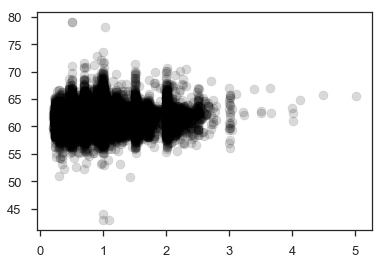

In [10]:
fig, ax = plt.subplots()

ax.scatter(x='carat', y='depth', data=df, c='k', alpha=.15);

This isn't limited to just DataFrames. It supports anything that uses `__getitem__` (square-brackets) with string keys. Other than that, I don't have much to add to the [matplotlib documentation](http://matplotlib.org/).

### Pandas' Built-in Plotting
The metadata in DataFrames gives a bit better defaults on plots.

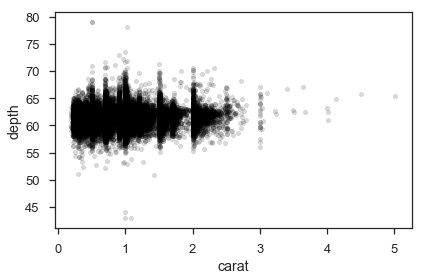

In [11]:
df.plot.scatter(x='carat', y='depth', c='k', alpha=.15)
plt.tight_layout()

We get axis labels from the column names. Nothing major, just nice.

Pandas can be more convenient for plotting a bunch of columns with a shared x-axis (the index), say several timeseries.

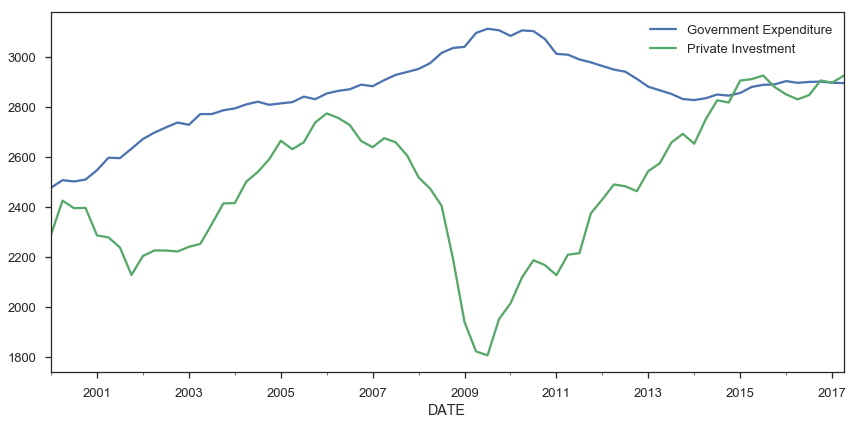

In [12]:
from pandas_datareader import fred

gdp = fred.FredReader(['GCEC96', 'GPDIC96'], start='2000-01-01').read()

gdp.rename(columns={"GCEC96": "Government Expenditure",
                    "GPDIC96": "Private Investment"}).plot(figsize=(12, 6))
plt.tight_layout()

### Seaborn

The rest of this post will focus on seaborn, and why I think it's especially great for exploratory analysis.

I would encourage you to read Seaborn's [introductory notes](https://stanford.edu/~mwaskom/software/seaborn/introduction.html#introduction), which describe its design philosophy and attempted goals. Some highlights:

> Seaborn aims to make visualization a central part of exploring and understanding data.

It does this through a consistent, understandable (to me anyway) API.

> The plotting functions try to do something useful when called with a minimal set of arguments, and they expose a number of customizable options through additional parameters.

Which works great for exploratory analysis, with the option to turn that into something more polished if it looks promising.

> Some of the functions plot directly into a matplotlib axes object, while others operate on an entire figure and produce plots with several panels.

The fact that seaborn is built on matplotlib means that if you are familiar with the pyplot API, your knowledge will still be useful.

Most seaborn plotting functions (one per chart-type) take an `x`, `y`, `hue`, and data arguments (only some are required, depending on the plot type). If you're working with DataFrames, you'll pass in strings referring to column names, and the DataFrame for `data`.

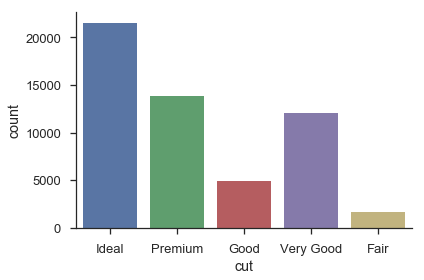

In [13]:
sns.countplot(x='cut', data=df)
sns.despine()
plt.tight_layout()

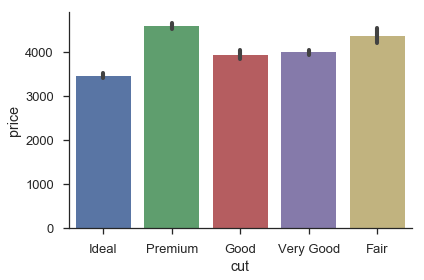

In [14]:
sns.barplot(x='cut', y='price', data=df)
sns.despine()
plt.tight_layout()

Bivariate relationships can easily be explored, either one at a time:

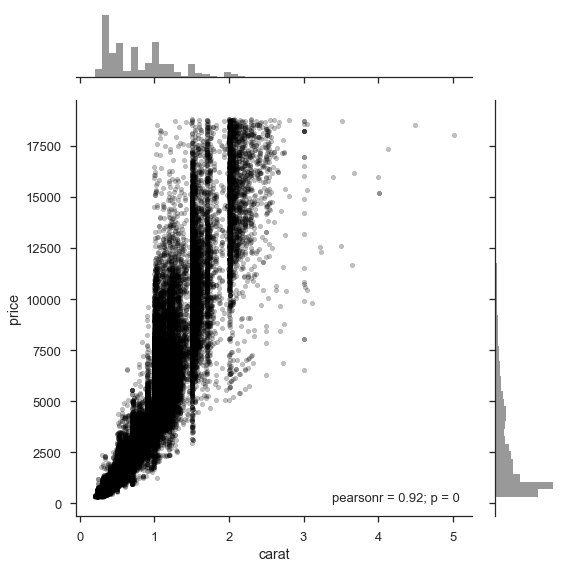

In [15]:
sns.jointplot(x='carat', y='price', data=df, size=8, alpha=.25,
              color='k', marker='.')
plt.tight_layout()

Or many at once

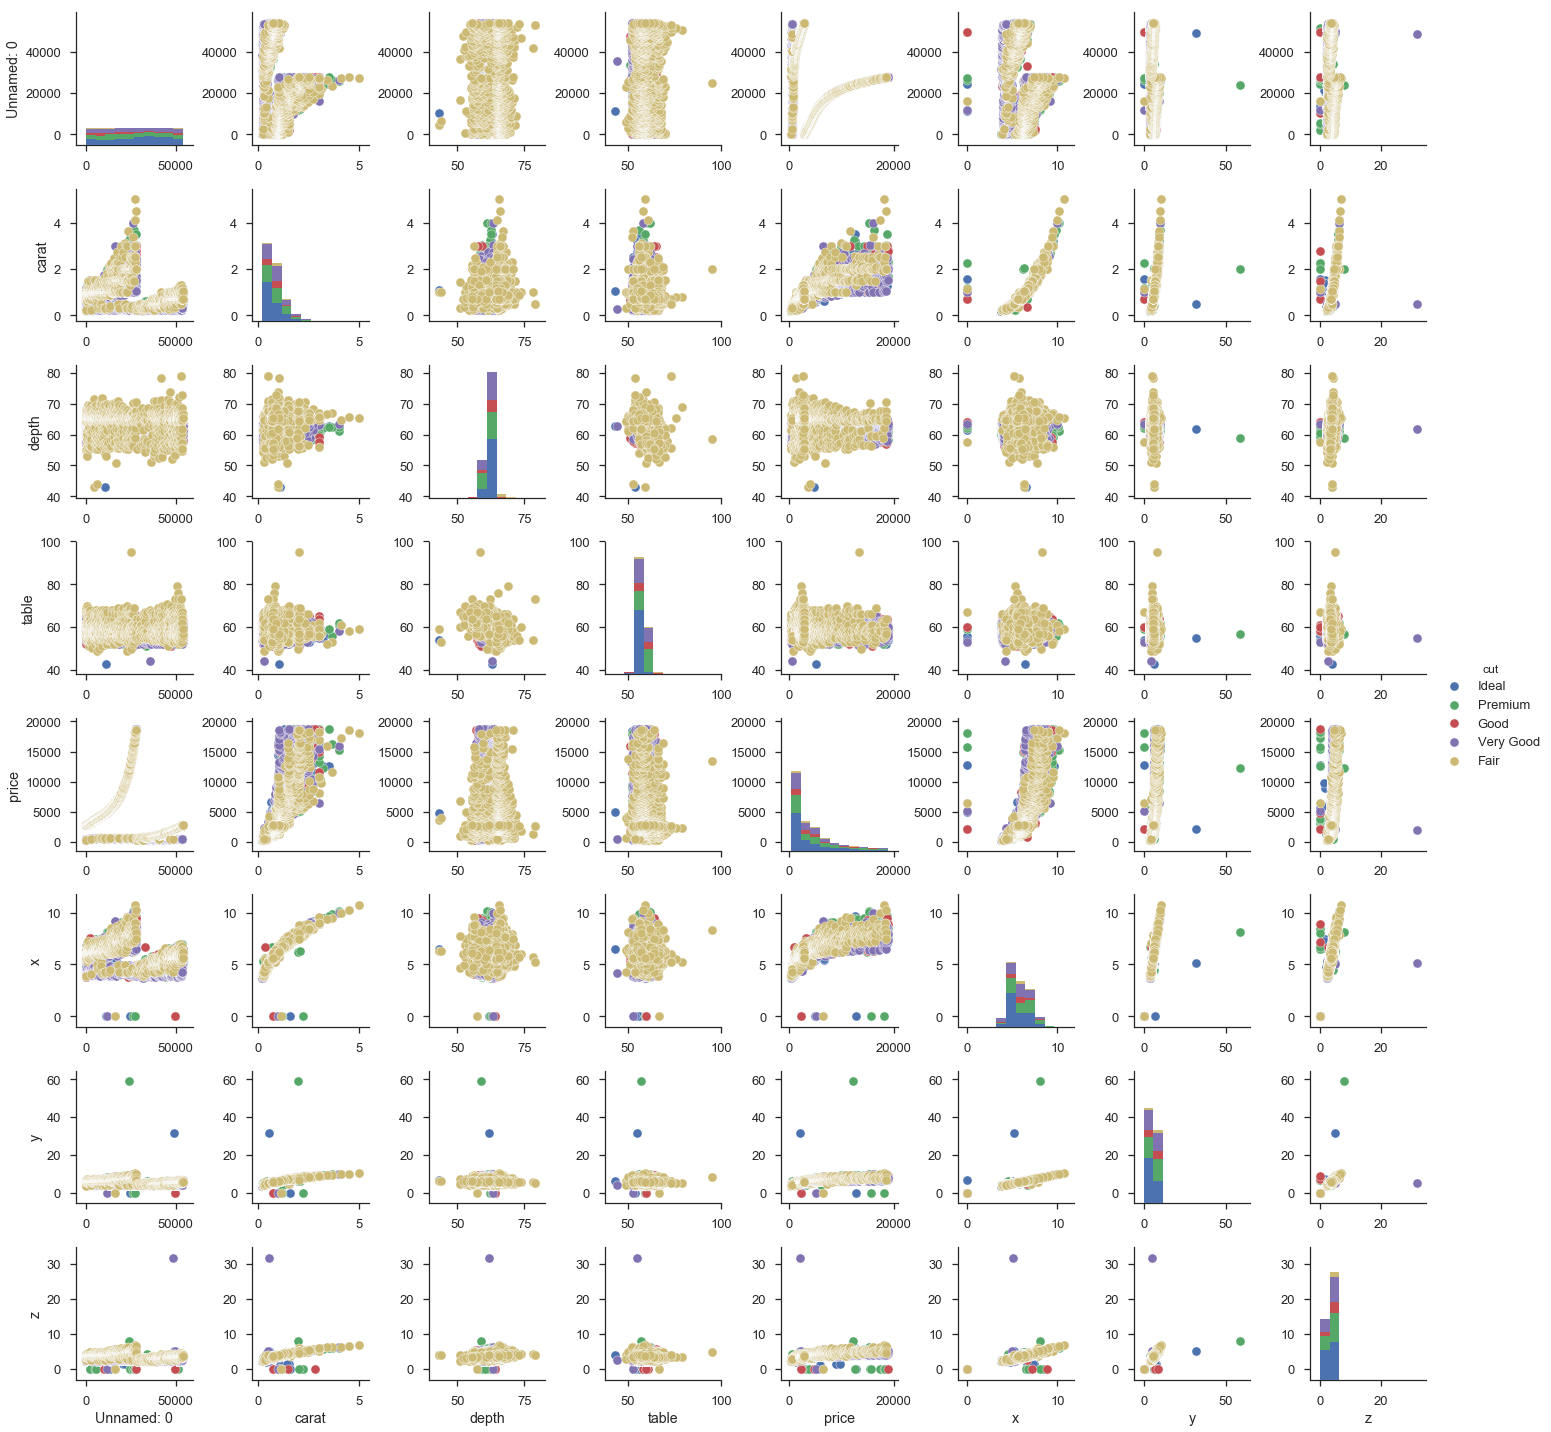

In [16]:
g = sns.pairplot(df, hue='cut')

`pairplot` is a convenience wrapper around `PairGrid`, and offers our first look at an important seaborn abstraction, the `Grid`. Seaborn Grids provide a link between a matplotlib `Figure` with multiple axes and features in your dataset.

There are two main ways of interacting with grids. First, seaborn provides convenience-wrapper functions like `pairplot`, that have good defaults for common tasks. If you need more flexibility, you can work with the Grid directly by mapping plotting functions over each axes.

In [17]:
def core(df, α=.05):
    mask = (df > df.quantile(α)).all(1) & (df < df.quantile(1 - α)).all(1)
    return df[mask]

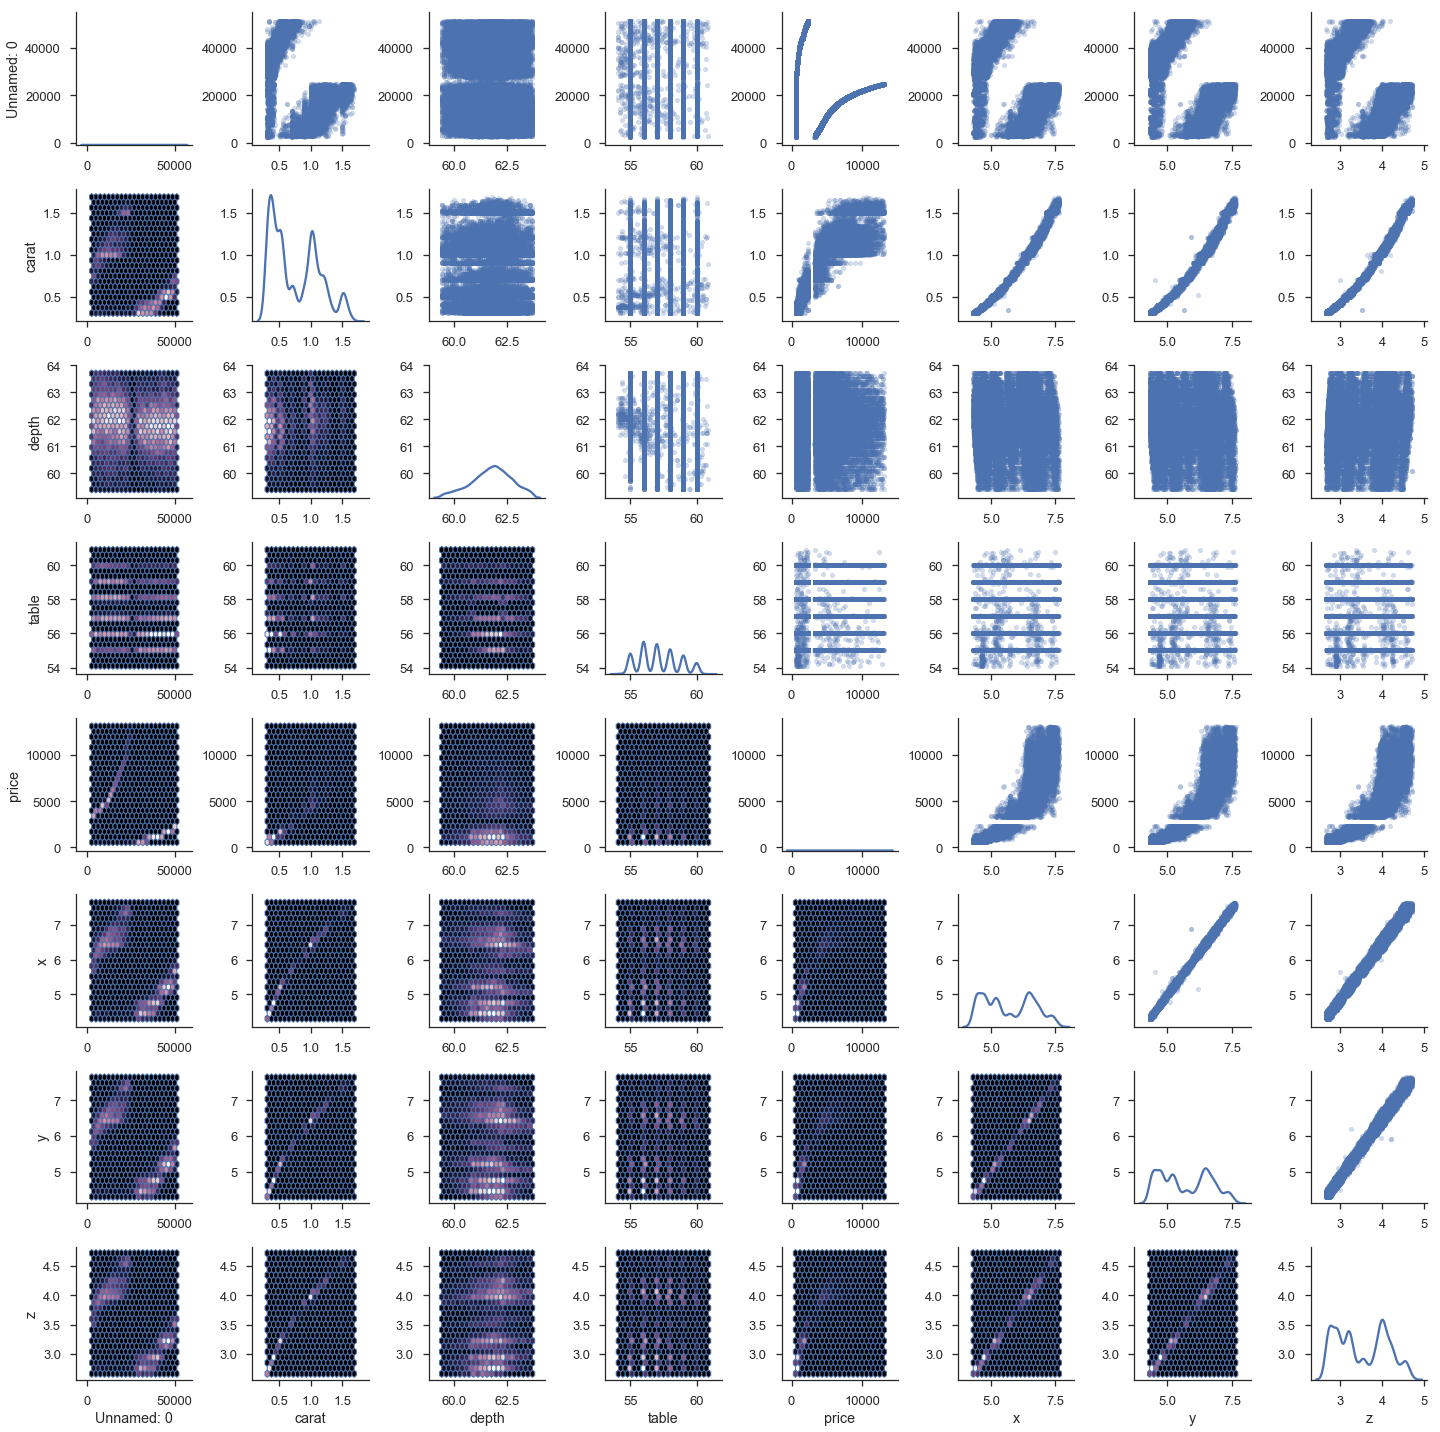

In [18]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)

(df.select_dtypes(include=[np.number])
   .pipe(core)
   .pipe(sns.PairGrid)
   .map_upper(plt.scatter, marker='.', alpha=.25)
   .map_diag(sns.kdeplot)
   .map_lower(plt.hexbin, cmap=cmap, gridsize=20)
);

This last example shows the tight integration with matplotlib. `g.axes` is an array of `matplotlib.Axes` and `g.fig` is a `matplotlib.Figure`. This is a pretty common pattern when using seaborn: use a seaborn plotting method (or grid) to get a good start, and then adjust with matplotlib as needed.

I think (not an expert on this at all) that one thing people like about the grammar of graphics is its flexibility. You aren't limited to a fixed set of chart types defined by the library author. Instead, you construct your chart by layering scales, aesthetics and geometries. And using ggplot2 in R is a delight.

That said, I wouldn't really call what seaborn / matplotlib offer that limited. You can create pretty complex charts suited to your needs.

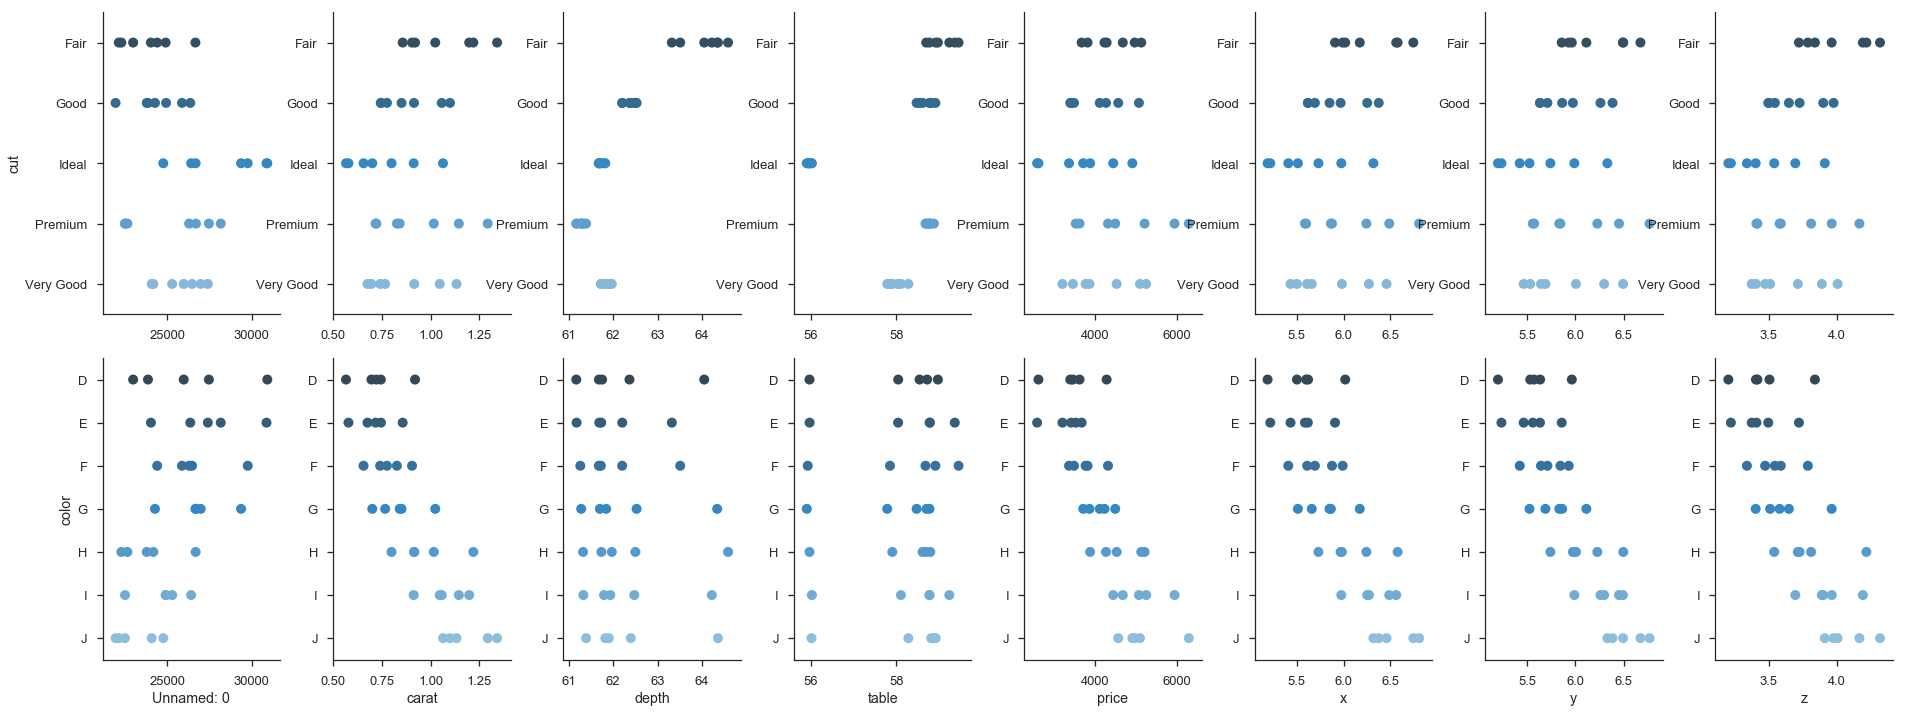

In [19]:
agged = df.groupby(['cut', 'color']).mean().sort_index().reset_index()

g = sns.PairGrid(agged, x_vars=agged.columns[2:], y_vars=['cut', 'color'],
                 size=5, aspect=.65)
g.map(sns.stripplot, orient="h", size=10, palette='Blues_d')

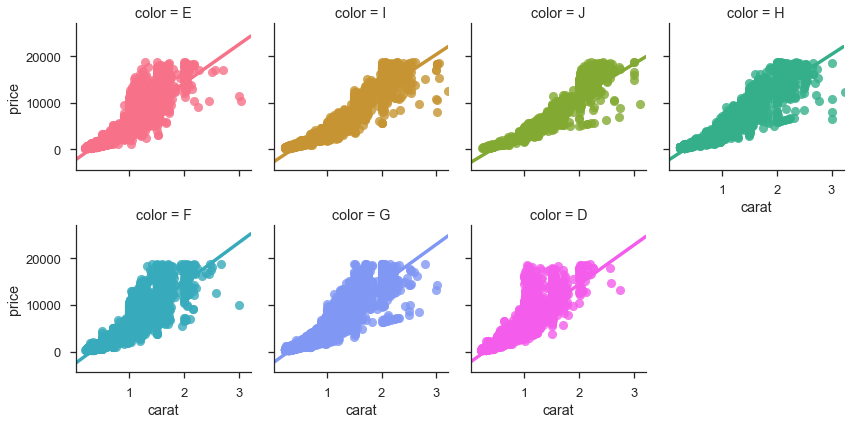

In [20]:
g = sns.FacetGrid(df, col='color', hue='color', col_wrap=4)
g.map(sns.regplot, 'carat', 'price')

Initially I had many more examples showing off seaborn, but I'll spare you. Seaborn's [documentation](https://stanford.edu/~mwaskom/software/seaborn/) is thorough (and just beautiful to look at).

We'll end with a nice scikit-learn integration for exploring the parameter-space on a GridSearch object.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

For those unfamiliar with machine learning or scikit-learn, the basic idea is your algorithm (`RandomForestClassifer`) is trying to maximize some objective function (percent of correctly classified items in this case). There are various hyperparameters that affect the fit. We can search this space by trying out a bunch of possible values for each parameter with the `GridSearchCV` estimator.

In [22]:
df = sns.load_dataset('titanic')

clf = RandomForestClassifier()
param_grid = dict(max_depth=[1, 2, 5, 10, 20, 30, 40],
                  min_samples_split=[2, 5, 10],
                  min_samples_leaf=[2, 3, 5])
est = GridSearchCV(clf, param_grid=param_grid, n_jobs=4)

y = df['survived']
X = df.drop(['survived', 'who', 'alive'], axis=1)

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(value=X.median())
est.fit(X, y);

In [23]:
scores = pd.DataFrame(est.cv_results_)
scores.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.038983,0.004524,0.784512,0.787318,1,2,2,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",55,0.757576,0.803030,0.811448,0.774411,0.784512,0.784512,0.001886,0.000320,0.021993,0.011851
1,0.034581,0.003438,0.787879,0.790685,1,2,5,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",54,0.757576,0.803030,0.818182,0.777778,0.787879,0.791246,0.005031,0.000412,0.024742,0.010317
2,0.038687,0.005001,0.782267,0.791246,1,2,10,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",56,0.771044,0.814815,0.818182,0.777778,0.757576,0.781145,0.009842,0.001511,0.025984,0.016722
3,0.044633,0.006134,0.781145,0.789001,1,3,2,"{'max_depth': 1, 'min_samples_leaf': 3, 'min_s...",57,0.754209,0.804714,0.801347,0.779461,0.787879,0.782828,0.006282,0.002425,0.019824,0.011195
4,0.046648,0.004203,0.775533,0.784512,1,3,5,"{'max_depth': 1, 'min_samples_leaf': 3, 'min_s...",61,0.771044,0.814815,0.797980,0.757576,0.757576,0.781145,0.003968,0.001351,0.016798,0.023489


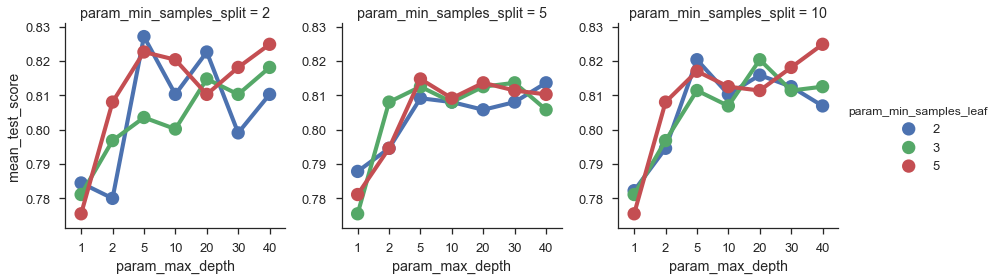

In [24]:
sns.factorplot(x='param_max_depth', y='mean_test_score',
               col='param_min_samples_split',
               hue='param_min_samples_leaf',
               data=scores);

Thanks for reading! I want to reiterate at the end that this is just my way of doing data visualization. Your needs might differ, meaning you might need different tools. You can still use pandas to get it to the point where it's ready to be visualized!